In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import galsim
from IPython.display import clear_output
from astropy.io import fits
from matplotlib.colors import LogNorm
from numpy import mgrid, sum
import scipy.linalg as alg
import scipy.stats as stats
from galsim.zernike import Zernike
import matplotlib

In [2]:
matplotlib.rcParams['figure.dpi']= 100
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [42]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16

cmap = sns.color_palette("colorblind")

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"




In [32]:
class shapeletXmoment:
    
    def __init__(self, psf,n, bmax = 10, pixel_scale = 1.0):
        self.n = n
        self.bmax = bmax
        self.pixel_scale = pixel_scale
        self.base_psf = psf
        self.base_psf_image = psf.drawImage(scale = pixel_scale)
        self.base_psf_result = galsim.hsm.FindAdaptiveMom(self.base_psf_image)
        self.base_shapelet = galsim.Shapelet.fit(self.base_psf_result.moments_sigma, bmax, self.base_psf_image, normalization = 'sb')
        self.base_bvec = self.base_shapelet.bvec
        
    def moment_measure(self, image, p, q):
        n = p+q
        
        if n<2:
            print( "Does not support moment measure less than second order.")
            return 0
        elif n==2:
            return self.get_second_moment(image,p,q)
        else:
            return self.higher_weighted_moment(image,p,q)
        
    def get_second_moment(self, image, p ,q):
        image_results = galsim.hsm.FindAdaptiveMom(image)
        if p==2:
            return image_results.observed_shape.e1
        elif q==2:
            return image_results.observed_shape.e2
        else:
            return image_results.moments_sigma
        
    def higher_weighted_moment(self,gsimage,p,q):
        
        image = gsimage.array
        

        y, x = mgrid[:image.shape[0],:image.shape[1]]+1

        psfresults = galsim.hsm.FindAdaptiveMom(galsim.Image(image, scale = self.pixel_scale))
        M = np.zeros((2,2))
        e1 = psfresults.observed_shape.e1
        e2 = psfresults.observed_shape.e2
        sigma4 = psfresults.moments_sigma**4
        c = (1+e1)/(1-e1)
        M[1][1] = np.sqrt(sigma4/(c-0.25*e2**2*(1+c)**2))
        M[0][0] = c*M[1][1]
        M[0][1] = 0.5*e2*(M[1][1]+M[0][0])
        M[1][0] = M[0][1]

        pos = np.array([x-psfresults.moments_centroid.x, y-psfresults.moments_centroid.y])
        pos = np.swapaxes(pos,0,1)
        pos = np.swapaxes(pos,1,2)


        inv_M = np.linalg.inv(M)
        sqrt_inv_M = alg.sqrtm(inv_M)
        std_pos = np.zeros(pos.shape)
        weight = np.zeros(pos.shape[0:2])
        for i in range(pos.shape[0]):
            for j in range(pos.shape[1]):
                this_pos = pos[i][j]
                this_standard_pos = np.matmul(sqrt_inv_M, this_pos)
                std_pos[i][j] = this_standard_pos
                weight[i][j] = np.exp(-0.5* this_standard_pos.dot(this_standard_pos))

        std_x, std_y = std_pos[:,:,0],std_pos[:,:,1]

        return sum(std_x**p*std_y**q*weight*image)/sum(image*weight)
    
    
    def modify_pq(self, m, c, delta = 0.0001):
        
        n = self.n
        mu = self.get_mu(n)
        pq_list = self.get_pq_full(n)
        shapelet_list = self.pq2shapelet(pq_list)

        ori_moments = self.get_all_moments(self.base_psf_image, pq_list)
        
        A = np.zeros(shape =(mu, mu))
        
        #i is the mode index
        #j is the moment index
        #measure d_moment_j / d_mode_i
        
        for i in range(mu):
            
            mode_index = shapelet_list[i]
            
            pert_bvec = self.base_bvec.copy()
            pert_bvec[mode_index]+=delta
            ith_pert = galsim.Shapelet(self.base_psf_result.moments_sigma, self.bmax, pert_bvec)
            pert_moment = self.get_all_moments(ith_pert.drawImage(scale = self.pixel_scale,method = 'no_pixel'), pq_list)
            for j in range(mu):
                A[i][j] = (pert_moment[j] - ori_moments[j])/delta     
        self.A = A


        dm = np.zeros(mu)
        dm += m*ori_moments + c
        ds = np.linalg.solve(A.T,dm)
        #print ds
        #print dm
        
        true_mod_bvec = self.base_bvec.copy()
        for i in range(mu):
            true_mod_bvec[shapelet_list[i]]+=ds[i]

        
        self.true_mod = galsim.Shapelet(self.base_psf_result.moments_sigma,  self.bmax, true_mod_bvec)
        return self.true_mod
    
    def step_modify_pq(self,current_moments,current_dm, current_mod_bvec ,current_psf,mu,shapelet_list,delta, pq_list):
        
        A = np.zeros(shape =(mu, mu))

        
        for i in range(mu):
            mode_index = shapelet_list[i]
            
            pert_bvec = current_mod_bvec.copy()
            pert_bvec[mode_index]+=delta
            ith_pert = galsim.Shapelet(self.base_psf_result.moments_sigma, self.bmax, pert_bvec)
            pert_moment = self.get_all_moments(ith_pert.drawImage(scale = self.pixel_scale), pq_list)
            for j in range(mu):
                A[i][j] = (pert_moment[j] - current_moments[j])/delta     


        ds = np.linalg.solve(A.T,current_dm)
        self.A = A
        
        for i in range(mu):
            current_mod_bvec[shapelet_list[i]]+=ds[i]
        return current_mod_bvec
            
    def iterative_modify_pq(self,m,c,delta = 0.0001, threshold = 1e-6):
        
        iterative_n = 10
        
        n = self.n
        mu = self.get_mu(n)
        pq_list = self.get_pq_full(n)
        shapelet_list = self.pq2shapelet(pq_list)
        base_shapelet_image = self.base_shapelet.drawImage(scale = self.pixel_scale)
        original_moment = self.get_all_moments(base_shapelet_image, pq_list)
        current_moment = self.get_all_moments(base_shapelet_image, pq_list)
        
        current_dm = np.zeros(mu)
        current_dm += m*current_moment + c
        
        destiny_moment = current_moment + current_dm
        
        current_mod_bvec = self.base_bvec.copy()
        current_psf = galsim.Shapelet(self.base_psf_result.moments_sigma,  self.bmax, current_mod_bvec)
        
        while (np.max(np.abs(current_dm)) > threshold):
            
            current_mod_bvec = self.step_modify_pq(current_moment,current_dm, current_mod_bvec ,current_psf,mu,shapelet_list,delta,pq_list)
            current_psf = galsim.Shapelet(self.base_psf_result.moments_sigma,  self.bmax, current_mod_bvec)
            current_moment = self.get_all_moments(current_psf.drawImage(scale = self.pixel_scale), pq_list)
            
            current_dm = destiny_moment - current_moment
            #print current_dm
            #print current_moment - original_moment
        return current_psf
                
    def get_all_moments(self, image, pq_list):
        results_list = []
        for tup in pq_list:
            results_list.append(self.moment_measure(image, tup[0], tup[1]))
                
        return np.array(results_list)
        
        
    def pq2mode(self,p,q):
        
        if p<=q:
            return (p+q)*(p+q+1)//2 + 2*min(p,q)
        else:
            return (p+q)*(p+q+1)//2 + 2*min(p,q)+1
        
        
        
    def pq2shapelet(self,pq_list):
        shapelet_index = []
        for tup in pq_list:
            shapelet_index.append(self.pq2mode(tup[0], tup[1]))
        return shapelet_index
        
        
        

        
        
    def get_mu(self, n):
        
        mu = 0
        for i in range(2,n+1):
            mu+=i+1
        return mu
    
    def get_pq_full(self,nmax):
        
        pq_list = []
        
        for n in range(2, nmax+1):
            p = 0
            q = n
            
            pq_list.append((p,q))
            
            while p<n:
                p+=1
                q-=1
                pq_list.append((p,q))
        return pq_list
    
    def get_pq_except(self,nmax,p,q):
        
        pq_full = self.get_pq_full(nmax)
        pq_except = []
        for tup in pq_full:
            if tup != (p,q):
                pq_except.append(tup)
                
        return pq_except
     
        

$<\frac{dm_i}{db_j}, \delta b_j> = \delta m_i$ 

In [33]:
psf = galsim.Gaussian(sigma = 5.0)
#psf = galsim.Kolmogorov(half_light_radius = 5.0)

sxm = shapeletXmoment(psf, 4)

sxm.higher_weighted_moment(sxm.base_psf_image,2,2)
fullpq = sxm.get_pq_full(4)
# simple test on p = 2,  q = 2 

m = np.zeros(12)
c = np.zeros(12)

true_mod = sxm.iterative_modify_pq(m,c)


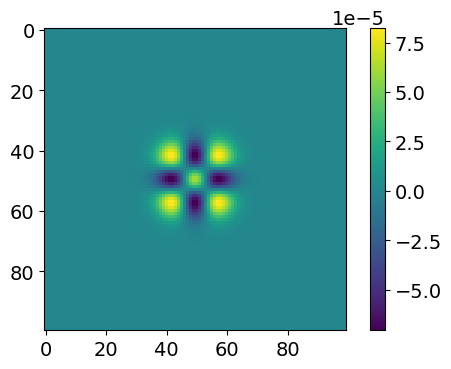

In [37]:
mod_image = true_mod.drawImage(scale = 1.0,method = 'no_pixel', nx = 100, ny = 100)
original_image = psf.drawImage(scale = 1.0, method = 'no_pixel', nx = 100, ny = 100)
plt.imshow(mod_image.array - original_image.array)
plt.colorbar()

In [38]:
ori_moment = sxm.get_all_moments(original_image, fullpq)
modi_moment = sxm.get_all_moments(mod_image, fullpq)

In [39]:
print( fullpq)

[(0, 2), (1, 1), (2, 0), (0, 3), (1, 2), (2, 1), (3, 0), (0, 4), (1, 3), (2, 2), (3, 1), (4, 0)]


In [40]:
print( modi_moment - ori_moment)

[-3.81570389e-17  0.00000000e+00 -2.98427948e-15  2.81487383e-18
 -5.00098188e-17 -4.78815103e-19 -2.77629452e-17  6.19517018e-07
  8.00952706e-18  1.00001944e-02 -1.66248082e-18  6.19517022e-07]


In [41]:
psf = galsim.Gaussian(sigma = 5.0)
sxm = shapeletXmoment(psf)
fullpq = sxm.get_pq_full(4)

ori_moment = sxm.get_all_moments(psf.drawImage(scale = 1.0, method = 'no_pixel'), fullpq)


plot_dm_1 = []
plot_moments_1 = np.zeros(shape = (12,20))
for i in range(20):
    c = 0.001*i
    
    
    plot_dm_1.append(c)
    this_mod = sxm.modify_pq(2, 2, 0.0, c)
    modi_moment = sxm.get_all_moments(this_mod.drawImage(scale = 1.0,method = 'no_pixel'), fullpq)
    diff = modi_moment - ori_moment
    plot_moments_1[:,i] = diff
    
    print (i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


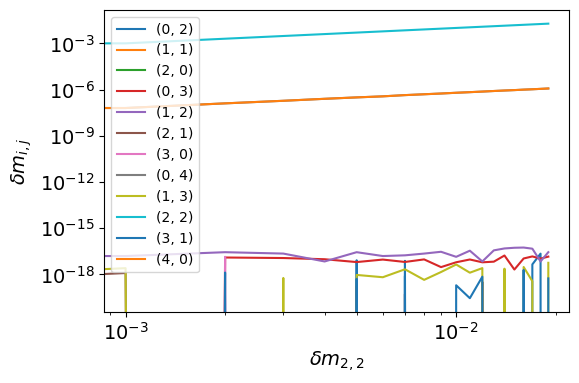

In [42]:
for i in range(12):
    plt.plot(plot_dm_1,plot_moments_1[i],label = str(fullpq[i]))
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$\delta m_{2,2}$")
plt.ylabel(r"$\delta m_{i,j}$")

plt.legend()

In [16]:
psf = galsim.Gaussian(sigma = 5.0)
sxm = shapeletXmoment(psf)
fullpq = sxm.get_pq_full(3)

ori_moment = sxm.get_all_moments(psf.drawImage(scale = 1.0, method = 'no_pixel'), fullpq)


plot_dm_2 = []
plot_moments_2 = np.zeros(shape = (7,20))
for i in range(20):
    c = 0.001*i
    plot_dm_2.append(c)
    this_mod = sxm.modify_pq(2, 1, 0.0, c)
    modi_moment = sxm.get_all_moments(this_mod.drawImage(scale = 1.0,method = 'no_pixel'), fullpq)
    diff = modi_moment - ori_moment
    plot_moments_2[:,i] = diff
    
    print( i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


No handles with labels found to put in legend.


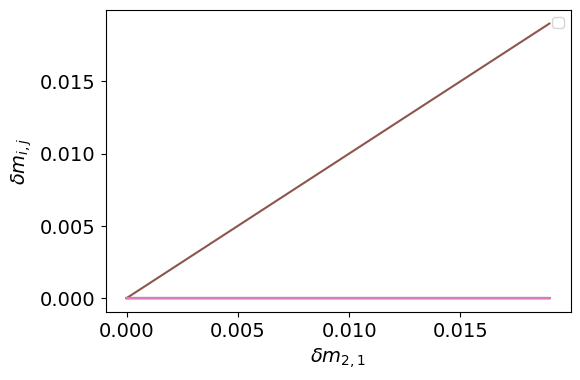

In [18]:
for i in range(7):
    plt.plot(plot_dm_2,plot_moments_2[i],)
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel(r"$\delta m_{2,1}$")
plt.ylabel(r"$\delta m_{i,j}$")
plt.legend()

In [18]:
psf = galsim.Gaussian(sigma = 5.0)
sxm = shapeletXmoment(psf)
fullpq = sxm.get_pq_full(4)

ori_image = psf.drawImage(scale = 1.0, method = 'no_pixel',nx = 100, ny = 100)

moments_profile = np.zeros(shape = (25,100,100))
for i in range(12):
    c = 0.001
    this_mod = sxm.modify_pq(fullpq[i][0],fullpq[i][1], 0.0, c)
    diff = this_mod.drawImage(scale = 1.0, method = 'no_pixel',nx = 100, ny = 100).array - ori_image.array
    moments_profile[i] = diff
    
    print( i)


TypeError: __init__() missing 1 required positional argument: 'n'

In [20]:
print( fullpq)

[(0, 2), (1, 1), (2, 0), (0, 3), (1, 2), (2, 1), (3, 0), (0, 4), (1, 3), (2, 2), (3, 1), (4, 0)]


In [ ]:
#pqlist = [(2,0,0),(2,0,1),(1,1,0),(3,0,0),(3,0,1),(2,1,0),(2,1,1),(4,0,0),(4,0,1),(3,1,0),(3,1,1),(2,2,0)]
fig = plt.figure(figsize = (21,15))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
axes = []
for j in range(25):
    #print j
    p,q = fullpq[j]
    n = p+q
    ax = plt.subplot(5,7,1+7*(n-2)+p)
    plt.imshow(moments_profile[j])
    plt.title(fullpq[j])
    #plt.show()
    
#fig.colorbar(axes)

In [10]:
three_components = [[-0.0187438 ,  0.00441243,  0.0097404,  -0.02930886, -0.72707707, -0.02072069,-0.16936806, -0.00853597, -0.66396272],
 [ 0.02527385, -0.00954157,  0.01059618, -0.05547384,  0.67788382,  0.0052362, -0.03638334,  0.01007761, -0.73150624],
 [-0.56677218, -0.19261926, -0.12135064, -0.79053345,  0.0032371,  -0.00653277,
   0.00246934, -0.00329989,  0.04390738]]

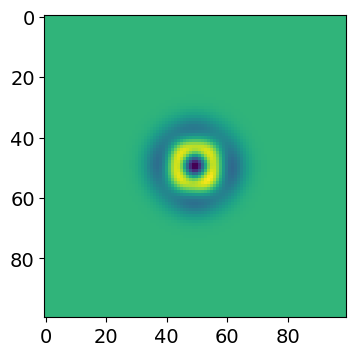

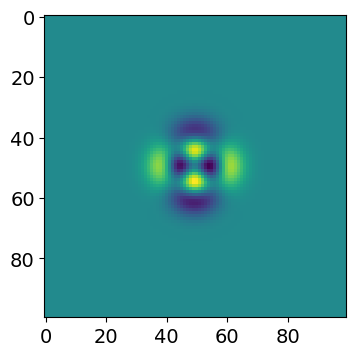

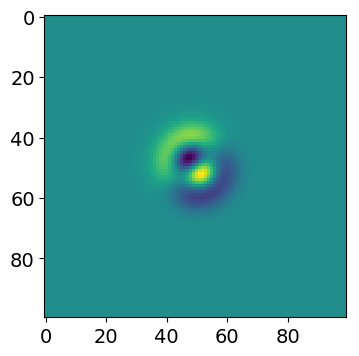

In [14]:
for i in range(3):
    new_basis = np.zeros((100,100))
    for j in range(9):
        new_basis += three_components[i][j] * moments_profile[j+3]
    plt.imshow(new_basis)
    plt.show()

In [17]:
psf = galsim.Kolmogorov(half_light_radius = 5.0)
sxm = shapeletXmoment(psf,4)
fullpq = sxm.get_pq_full(4)

ori_moment = sxm.get_all_moments(psf.drawImage(scale = 1.0, method = 'no_pixel'), fullpq)


plot_dm_3 = []
plot_moments_3 = np.zeros(shape = (7,20))
for i in range(12):
    c = 0.001
    m = np.zeros(12)
    c = np.zeros(12)
    c[i] = 0.001
    plot_dm_3.append(c)
    this_mod = sxm.modify_pq(m,c)
    modi_moment = sxm.get_all_moments(this_mod.drawImage(scale = 1.0,method = 'no_pixel'), fullpq)
    #diff = modi_moment - ori_moment
    #plot_moments_3[:,i] = diff
    
    print( i)


ValueError: could not broadcast input array from shape (12,) into shape (7,)

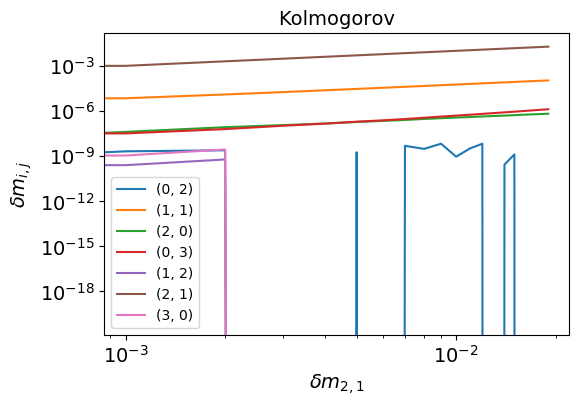

In [325]:
for i in range(7):
    plt.plot(plot_dm_3,plot_moments_3[i],label = str(pq_list[i]))
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$\delta m_{2,1}$")
plt.ylabel(r"$\delta m_{i,j}$")
plt.title('Kolmogorov')
plt.legend()

In [60]:
psf = galsim.Kolmogorov(half_light_radius = 2.0)
sxm = shapeletXmoment(psf,4)
fullpq = sxm.get_pq_full(4)

#ori_image = psf.drawImage(scale = 1.0, method = 'no_pixel',nx = 100, ny = 100)
ori_image = sxm.base_shapelet.drawImage(scale = 1.0, nx = 70, ny = 70)
ori_moments = sxm.get_all_moments(sxm.base_shapelet.drawImage(scale=1.0), fullpq)

moments_profile_kol = np.zeros(shape = (12,70,70))
for i in range(0,12):
    c = 0.001
    m = np.zeros(12)
    c = np.zeros(12)
    c[i] = 0.001
    this_mod = sxm.iterative_modify_pq(m,c,threshold = 1e-6)
    diff = this_mod.drawImage(scale = 1.0,nx = 70, ny = 70).array - ori_image.array
    moments_profile_kol[i] = diff
    
    modi_moments = sxm.get_all_moments(this_mod.drawImage(scale = 1.0),fullpq)
    
    moment_change = modi_moments - ori_moments
    print(i, moment_change)
    


0 [ 1.00004356e-03  0.00000000e+00 -3.81593974e-08 -2.26025834e-08
  6.79033398e-09  2.85312755e-09  1.34975998e-08 -8.62349938e-08
 -1.03386403e-08 -1.79163956e-07 -1.40946338e-08 -6.88676552e-08]
1 [-9.47988266e-08  1.00004673e-03  1.25450276e-07  1.58174740e-08
 -1.17950893e-08  6.24588839e-09 -3.40270793e-08 -1.38791861e-08
  2.26261785e-08 -2.67478221e-08  2.23308165e-08 -1.23059856e-07]
2 [ 7.94448951e-09  0.00000000e+00  1.00000262e-03  8.35434227e-09
 -1.34822270e-09  7.53528750e-09 -3.20019116e-09 -9.07127788e-08
  1.25345451e-09  4.62756007e-08  5.42839575e-09 -1.32300878e-07]
3 [ 3.38362884e-08  1.19209290e-07 -3.22905914e-07  9.99975161e-04
  3.43135735e-10 -6.09789572e-09 -9.87583418e-10 -1.76325973e-07
 -1.78715822e-08  2.08076051e-09 -2.68774309e-08  4.42240254e-08]
4 [-4.42429897e-08  1.19209290e-07 -3.74633908e-07 -4.96388611e-08
  1.00003295e-03 -2.09808022e-08  3.59230413e-08 -2.23191447e-07
 -2.08991002e-08 -1.25867331e-07 -9.55565318e-09 -1.78451385e-08]
5 [ 6.3315

In [32]:
import pickle

with open("../plots2/pickle/moment_basis.pkl","wb") as f:
    pickle.dump([moments_profile_kol,fullpq ],f)

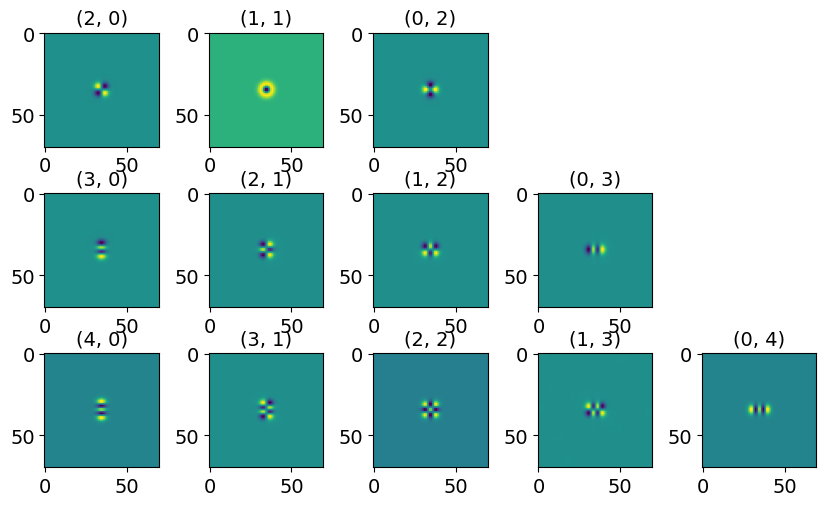

In [80]:
pqlist = [(2,0,0),(2,0,1),(1,1,0),(3,0,0),(3,0,1),(2,1,0),(2,1,1),(4,0,0),(4,0,1),(3,1,0),(3,1,1),(2,2,0)]
fig = plt.figure(figsize = (10,10))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
axes = []
for j in range(12):
    p,q,i = pqlist[j]
    ax = plt.subplot(5,5,1+5*(p+q)+2*q+i)
    plt.imshow(moments_profile_kol[j])
    plt.title(str((fullpq[j][1], fullpq[j][0])))
    #plt.show()
    
#fig.colorbar(axes)

In [81]:
for i in range(12):
    p,q,k = pqlist[j]
    
    moment_i = moments_profile_kol[i]
    i_norm = np.sum(moment_i*moment_i)

    
    for j in range(i,12):
        moment_j = moments_profile_kol[j]
        j_norm = np.sum(moment_j*moment_j)

        
        #print(i,j)
        print(i,j,np.sum(moment_i*moment_j)/np.sqrt(i_norm*j_norm))

0 0 1.0
0 1 2.3835186050707556e-05
0 2 5.038068709799155e-05
0 3 -2.110930274958106e-05
0 4 -3.518927960715043e-05
0 5 -7.13024781124432e-05
0 6 9.037070318351505e-05
0 7 4.017157559568624e-05
0 8 -3.554990264550038e-05
0 9 -0.00010390567630602708
0 10 -3.257737373965475e-05
0 11 -1.8037597749571e-05
1 1 1.0
1 2 3.0483073959002664e-06
1 3 2.884851655343126e-06
1 4 4.2160156934459286e-05
1 5 1.9833033579064393e-05
1 6 2.2005862514203377e-05
1 7 0.00010501124831280539
1 8 -7.183897034417877e-06
1 9 3.80003242615078e-06
1 10 -1.667824610284451e-05
1 11 0.0001157060370610809
2 2 1.0
2 3 7.476688556843691e-05
2 4 -4.4453731963430354e-05
2 5 -3.169494005526848e-05
2 6 3.8858057516824046e-05
2 7 0.0001543709073263506
2 8 -2.7205636471370516e-05
2 9 -3.316363826678827e-05
2 10 1.2709540606448679e-05
2 11 6.640173812125086e-05
3 3 1.0
3 4 1.168182563375982e-05
3 5 0.0003613026690803047
3 6 9.213871746644485e-06
3 7 1.2360116466896474e-05
3 8 2.2134661170786166e-05
3 9 -1.9994576792909217e-05
3 

In [303]:
normalize_moment_base = moments_profile.copy()
for i in range(12):
    normalize_moment_base[i] = normalize_moment_base[i] / np.sqrt(np.sum(normalize_moment_base[i]**2))

In [305]:
kronecker = np.zeros(shape = (12,12))
for i in range(12):
    for j in range(12):
        kronecker[i][j] = np.sum(normalize_moment_base[i]*normalize_moment_base[j])

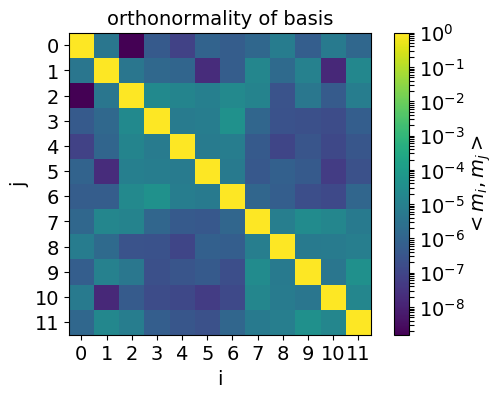

In [321]:
plt.imshow(abs(kronecker),norm = LogNorm())
plt.xticks(list(range(0,12)))
plt.yticks(list(range(0,12)))
plt.xlabel('i')
plt.ylabel('j')

plt.title("orthonormality of basis")
plt.colorbar(label = r"$<m_i,m_j>$")

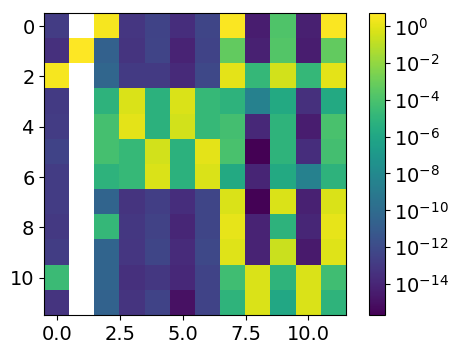

In [337]:
plt.imshow(np.abs(sxm.A),norm = LogNorm())
plt.
plt.colorbar()

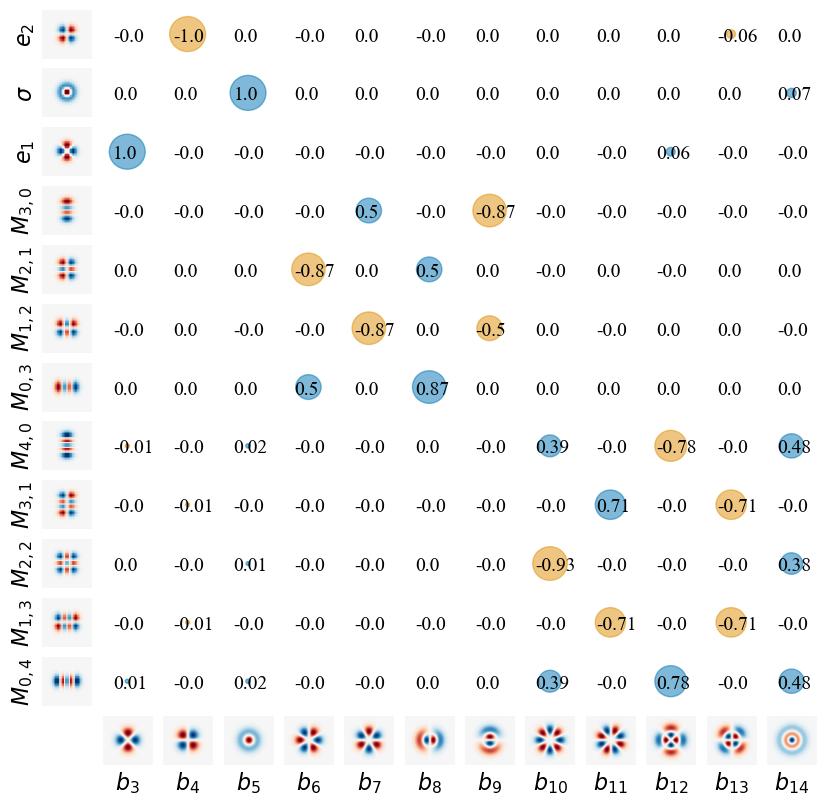

In [61]:
pqlist = [(0,0,0),(1,0,0),(1,0,1),(2,0,0),(2,0,1),(1,1,0),(3,0,0),(3,0,1),(2,1,0),(2,1,1),(4,0,0),(4,0,1),(3,1,0),(3,1,1),(2,2,0)]
shapelet_list = sxm.pq2shapelet(fullpq)
fullpq = sxm.get_pq_full(4)
second_title = [r'$e_2$', r'$\sigma$',r'$e_1$']



#Set the size and config of the plot
fig = plt.figure(figsize = (10,10))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)

#Plot the first column: 2-d distribution
for i in range(12):
    ax = plt.subplot(13,13,1+i*13, frame_on = False)
    vabs = np.max(np.abs(moments_profile_kol[i][20:50, 20:50]))
    plt.imshow(moments_profile_kol[i][25:45, 25:45],cmap = 'RdBu', vmin = -vabs, vmax = vabs)
    p,q = fullpq[i][1], fullpq[i][0]
    plt.axis('on')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_ticks([])
    
    if i<3:
        plt.ylabel(second_title[i])
    else:
        plt.ylabel(r'$M_{'+str(p)+','+str(q)+'}$')
    
#Plot the last row: 2-d distribution  
for j in range(12):
    ax = plt.subplot(13,13,12*13+j+2, frame_on = False)
    p,q,i = pqlist[j+3]
    bvec = np.zeros((15))
    bvec[j+3] = 1.0
    
    shapelet = galsim.Shapelet(5.0, 4, bvec)
    vabs = np.max(np.abs(shapelet.drawImage(scale = 1.0).array))
    plt.imshow(shapelet.drawImage(scale = 1.0, nx = 50, ny = 50).array,cmap = 'RdBu', vmin = -vabs, vmax = vabs)
    plt.axis('on')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_ticks([])
    plt.xlabel(r'$b_{'+str(j+3)+'}$')

#max_A = np.max(np.abs(sxm.A))
#Plot the weight in text and circle
for i in range(12):
    colume_number = shapelet_list[i]+1-3
    for j in range(12):
        row_number = j
        
        ax = plt.subplot(13,13,row_number*13 + colume_number + 1 , frame_on = False)
        
        length = np.linalg.norm(sxm.A[:,j])
        
        
        #Set circle size, color, and position
        circle_size = (np.abs(sxm.A[i][j])/length)**(0.5)/2
        if sxm.A[i][j]>0:
            color_code = cmap[0]
        else:
            color_code = cmap[1]
        circle = plt.Circle((0.5, 0.5), circle_size , color=color_code, alpha = 0.5)
        ax.add_artist(circle)
        plt.xlim([-0.2,1.2])
        plt.ylim([-0.2,1.2])
        
        #Plot the circle
        s = str(round(sxm.A[i][j]/length,2))
        plt.text(0.1, 0.3, s ,fontsize = 14)
        plt.axis('off')
        
plt.savefig('../plots2/Tij.pdf', dpi = 300)
plt.show()
    
    

In [63]:
sxm.A.shape

(12, 12)

In [417]:
print galsim.hsm.FindAdaptiveMom(true_mod.drawImage(scale = 1.0,method = 'no_pixel'))

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=136, ymin=1, ymax=136), moments_status=0L, observed_shape=galsim.Shear((7.105427198782324e-17-1.7193364276582182e-17j)), moments_sigma=5.0, moments_amp=1.0, moments_centroid=galsim.PositionD(x=68.5, y=68.5), moments_rho4=2.020001589775445, moments_n_iter=4L, correction_status=-10L)
